In [2]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

### Load Snodgrass met observations
Dowloaded Mark Raleigh's data from https://markraleigh.com/snodgrass/wx.html
June 2024


In [3]:
fin = '/glade/campaign/cgd/tss/people/wwieder/gothic/snodgrass_met/'
fin = fin + 'SND_opn_AWS_data_001hr.csv'

colnames=['year', 'month', 'day', 'hour', 'minute', 'TBOT','RH',
         'wind','wind_max','in_short','out_short','in_long','skin_temp',
         'snow_depth','accum_precip'] 
df = pd.read_csv(fin, names=colnames, header=None)
df.tail()

,year,month,day,hour,minute,TBOT,RH,wind,wind_max,in_short,out_short,in_long,skin_temp,snow_depth,accum_precip
42452,2023,10,21,20,0,7.6645,27.639,2.7699,3.327,0.0,0.0,237.50,0.82415,17.945,37.77
42453,2023,10,21,21,0,6.9711,30.015,2.6375,3.087,0.0,0.0,234.14,-0.31800,19.784,37.77
42454,2023,10,21,22,0,6.3595,31.528,2.5039,3.087,0.0,0.0,233.94,-1.17370,20.939,37.77
42455,2023,10,21,23,0,6.4420,33.552,2.4843,3.087,0.0,0.0,236.10,-1.07640,19.558,37.77
42456,2023,10,22,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


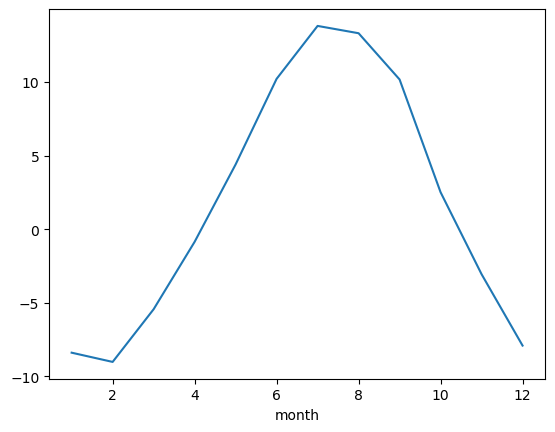

In [5]:
# Add time as datetime from dates provied
df2 = df[colnames[0:5]]
df['time'] = pd.to_datetime(df2)
df.groupby(df.month).mean().TBOT.plot() ;

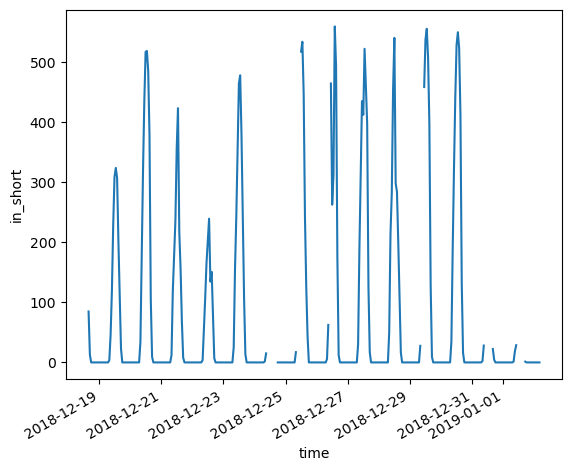

In [6]:
ds = df.set_index('time')[colnames[5:]].to_xarray()
ds.isel(time=slice(0,365)).in_short.plot() ;

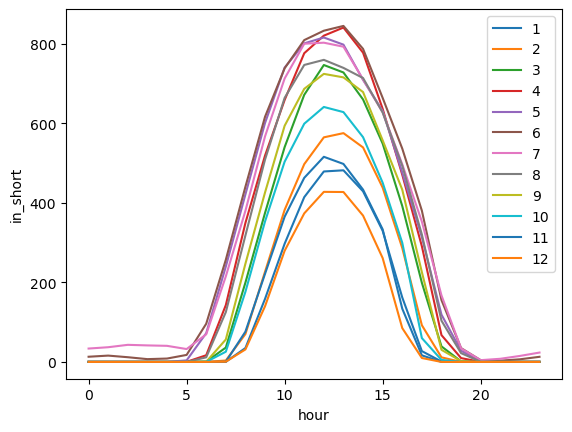

In [7]:
# odd values for a few months, June & july, non-zero mean nighttime measurements
# evident if plotting max values.
for i in range(1,13):
    temp = ds.sel(time=ds.time.dt.month.isin([i])) 
    temp.in_short.groupby("time.hour").mean().plot(label=i)
plt.legend() ;

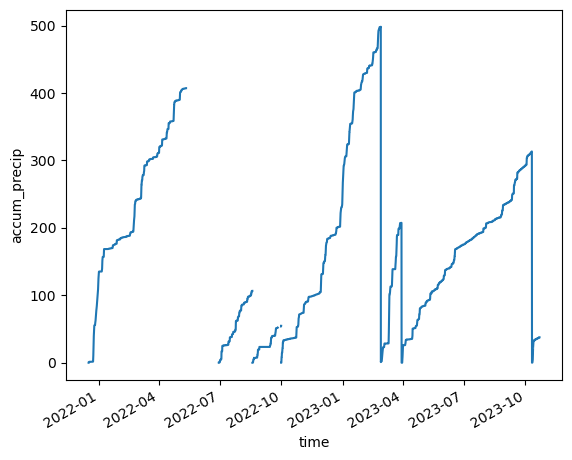

In [8]:
ds.accum_precip.plot() ;

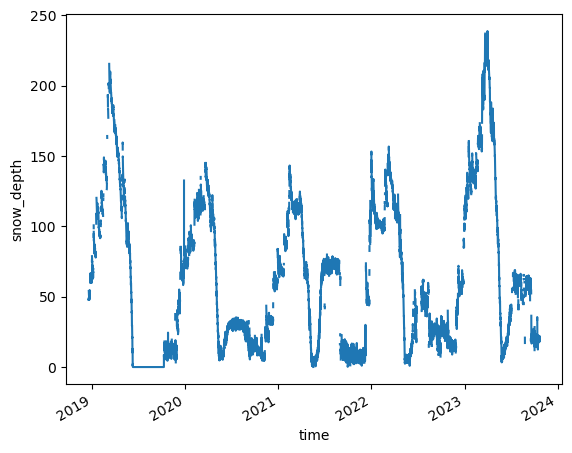

In [9]:
ds.snow_depth.plot()

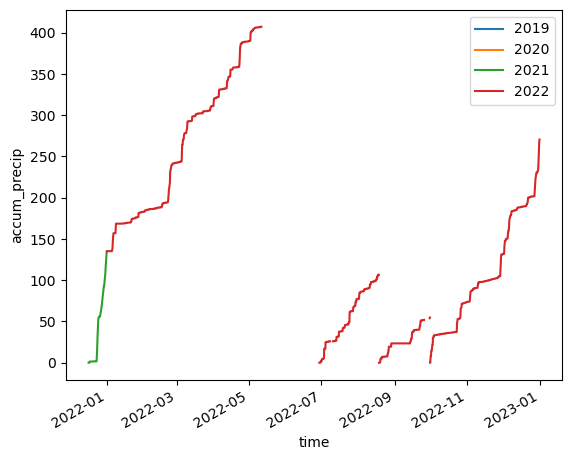

In [7]:
for i in range(2019,2023):
    temp = ds.sel(time=ds.time.dt.year.isin([i])) 
    temp.accum_precip.plot(label=i)
plt.legend() ;

## Gap fill observational data
Taking a day-of-year hourly climatology still results in data gaps

In [8]:
# create index for gap filling by (by year, month, hour, or just month-hour?)
year_month_hour_idx = pd.MultiIndex.from_arrays([df['year'],df['month'], df['hour']])
year_month_hour_idx
ds.coords['Yearmonth_hour'] = ('time', year_month_hour_idx)
temp = ds.groupby('Yearmonth_hour').mean()

# Gap fill full dataset
filled1 = ds.in_short.groupby("Yearmonth_hour").fillna(temp.in_short)
filled2 = ds.in_long.groupby("Yearmonth_hour").fillna(temp.in_long)
filled3 = ds.TBOT.groupby("Yearmonth_hour").fillna(temp.TBOT)
both = xr.Dataset({"orig_short": ds.in_short, "in_short": filled1,
                  "orig_long": ds.in_long, "in_long": filled2,
                  "orig_TBOT": ds.TBOT, "TBOT": filled3})
both

<xarray.Dataset>
Dimensions:         (time: 42457)
Coordinates:
  * time            (time) datetime64[ns] 2018-12-18 ... 2023-10-22
    Yearmonth_hour  (time) object (2018, 12, 0) (2018, 12, 1) ... (2023, 10, 0)
Data variables:
    orig_short      (time) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 nan
    in_short        (time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    orig_long       (time) float64 nan nan nan nan nan ... 234.1 233.9 236.1 nan
    in_long         (time) float64 227.5 231.6 233.2 234.9 ... 233.9 236.1 239.4
    orig_TBOT       (time) float64 nan nan nan nan nan ... 6.971 6.359 6.442 nan
    TBOT            (time) float64 -10.25 -10.26 -10.46 ... 6.359 6.442 3.054

## Look at gap filled results

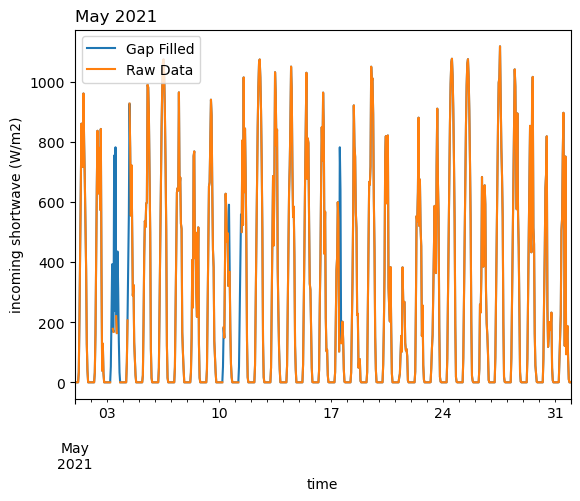

In [9]:
temp = both.sel(time=ds.time.dt.year.isin(2021))
df2 = temp.sel(time=temp.time.dt.month.isin(5)).reset_coords(drop=True).to_dataframe()
df2[["in_short","orig_short"]].plot() 
plt.ylabel('incoming shortwave (W/m2)')
plt.title('May 2021', loc='left');
plt.legend(['Gap Filled','Raw Data'])

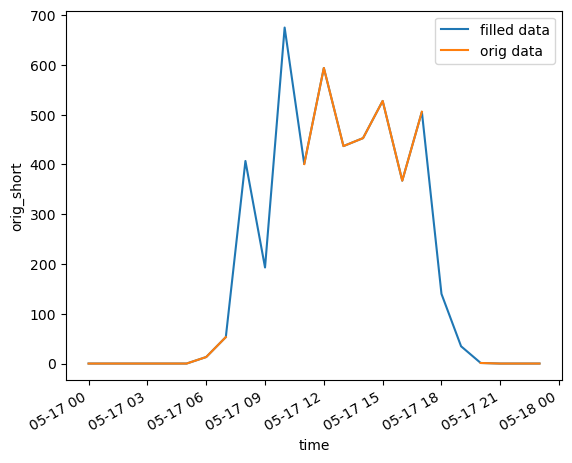

In [10]:
temp = both.sel(time=both.time.dt.year.isin(2019))#, time=both.time.dt.month.isin(5))
temp = temp.sel(time=temp.time.dt.month.isin(5))
first, last = 16*24,17*24
temp.isel(time=slice(first,last)).in_short.plot(label ='filled data')
temp.isel(time=slice(first,last)).orig_short.plot(label='orig data')
plt.legend() ;

## Create climatology

In [11]:
# Shift for UTC
shift = 6
ds2 = both.shift(time=shift)
ds2 = ds2.isel(time=slice(shift,None))
ds2.time

<xarray.DataArray 'time' (time: 42451)>
array(['2018-12-18T06:00:00.000000000', '2018-12-18T07:00:00.000000000',
       '2018-12-18T08:00:00.000000000', ..., '2023-10-21T22:00:00.000000000',
       '2023-10-21T23:00:00.000000000', '2023-10-22T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time            (time) datetime64[ns] 2018-12-18T06:00:00 ... 2023-10-22
    Yearmonth_hour  (time) object (2018, 12, 6) (2018, 12, 7) ... (2023, 10, 0)

In [12]:
# Drop leap days
ds2 = ds2.convert_calendar('noleap')
# Then group by dayHourly
test = (ds2['time.hour']/24 + ds2['time.dayofyear'])
test.name = 'dayHourly'
climo = ds2.groupby(test).median(dim='time')
climo

<xarray.Dataset>
Dimensions:     (dayHourly: 8760)
Coordinates:
  * dayHourly   (dayHourly) float64 1.0 1.042 1.083 1.125 ... 365.9 365.9 366.0
Data variables:
    orig_short  (dayHourly) float64 0.0 0.0 0.0 0.0 ... 483.0 372.4 77.77 7.426
    in_short    (dayHourly) float64 0.0 0.0 0.0 0.0 ... 390.8 297.7 88.14 10.26
    orig_long   (dayHourly) float64 228.9 228.0 250.3 ... 195.1 229.4 228.8
    in_long     (dayHourly) float64 224.0 227.1 248.0 ... 224.2 219.4 223.4
    orig_TBOT   (dayHourly) float64 -7.849 -7.876 -9.354 ... -5.22 -5.723 -6.907
    TBOT        (dayHourly) float64 -7.849 -7.876 -9.354 ... -5.22 -5.723 -6.907

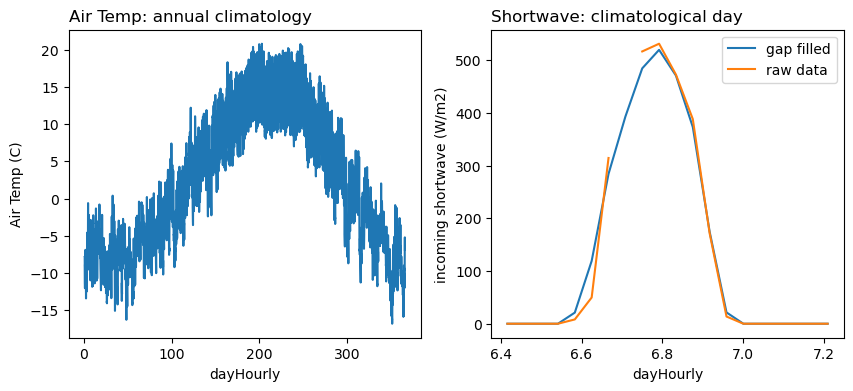

In [13]:
plt.figure(figsize=[10,4])
plt.subplot(1, 2, 1)
climo.TBOT.plot()
plt.title('Air Temp: annual climatology', loc='left')
plt.ylabel('Air Temp (C)')
plt.subplot(1, 2, 2)
climo.in_short.isel(dayHourly=slice(130,150)).plot(label='gap filled') ;
climo.orig_short.isel(dayHourly=slice(130,150)).plot(label='raw data') ;
plt.title('Shortwave: climatological day', loc='left')
plt.ylabel('incoming shortwave (W/m2)')
plt.legend() ;

In [14]:
#fout = both.reset_coords(drop=True).to_dataframe()
#fout.head()

## look at raw data from NLDAS

In [15]:
ds = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic.2020-2022.nc',
                     decode_times=True)
ds2 = xr.open_dataset('/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic.2020-2022.nc',
                     decode_times=True)

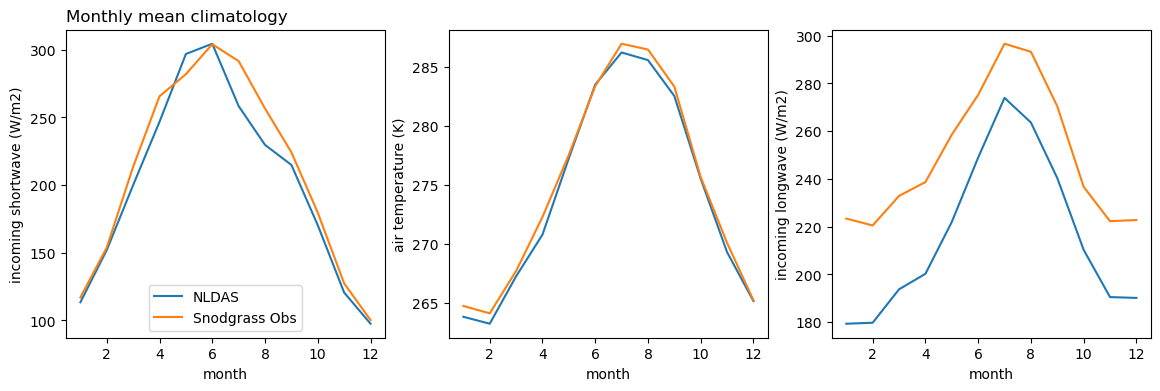

In [16]:
plt.figure(figsize=[14,4])
plt.subplot(1, 3, 1)
ds.FSDS.isel(lat=0,lon=0).groupby('time.month').mean().plot(label='NLDAS')
both.in_short.groupby('time.month').mean().plot(label='Snodgrass Obs') 
plt.legend()
plt.title('Monthly mean climatology', loc='left')
plt.ylabel('incoming shortwave (W/m2)') ; 

plt.subplot(132)
ds2.TBOT.isel(lat=0,lon=0).groupby('time.month').mean().plot()
(both.TBOT.groupby('time.month').mean()+273.15).plot() ;
plt.ylabel('air temperature (K)') ; 

plt.subplot(133)
ds2.FLDS.isel(lat=0,lon=0).groupby('time.month').mean().plot()
both.in_long.groupby('time.month').mean().plot() 
plt.ylabel('incoming longwave (W/m2)') ; 

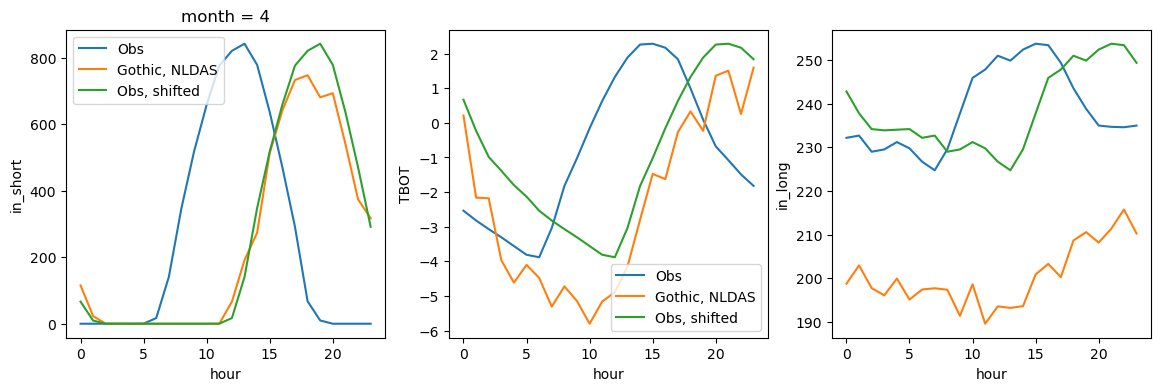

In [17]:
nmonth = 4

plt.figure(figsize=[14,4])
plt.subplot(131)
both2=both.shift(time=shift)
both.in_short.sel(time=both.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Obs')
ds.FSDS.sel(time=ds.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Gothic, NLDAS')
both2.in_short.sel(time=both2.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Obs, shifted')
plt.legend();
plt.title('month = '+str(nmonth))

plt.subplot(132)
both.TBOT.sel(time=both.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Obs')
(ds2.TBOT.isel(lat=0,lon=0).sel(time=ds2.time.dt.month.isin([nmonth]))-273.15) \
    .groupby('time.hour').mean().plot(label='Gothic, NLDAS')
both2.TBOT.sel(time=both2.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Obs, shifted')
plt.legend();

plt.subplot(133)
both.in_long.sel(time=both.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Obs')
ds2.FLDS.isel(lat=0,lon=0).sel(time=ds2.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Gothic, NLDAS')
both2.in_long.sel(time=both2.time.dt.month.isin([nmonth])) \
    .groupby('time.hour').mean().plot(label='Obs, shifted') ;

In [18]:
data= np.concatenate((climo.in_short.values,climo.in_short.values,climo.in_short.values))
data2= np.concatenate((climo.TBOT.values,climo.TBOT.values,climo.TBOT.values)) + 273.15
data3= np.concatenate((climo.in_long.values,climo.in_long.values,climo.in_long.values))
data2[0:12]

array([265.3009, 265.2741, 263.7965, 262.896 , 262.249 , 261.967 ,
       261.705 , 261.59  , 261.093 , 264.2716, 263.378 , 263.5727])

In [19]:
ds2

<xarray.Dataset>
Dimensions:  (time: 26280, lat: 1, lon: 1)
Coordinates:
  * time     (time) object 2020-01-01 00:00:00 ... 2022-12-31 23:00:03.515625
  * lon      (lon) float32 253.1
  * lat      (lat) float32 38.94
Data variables:
    LONGXY   (lat, lon) float32 ...
    LATIXY   (lat, lon) float32 ...
    TBOT     (time, lat, lon) float32 ...
    PSRF     (time, lat, lon) float32 ...
    QBOT     (time, lat, lon) float32 ...
    WIND     (time, lat, lon) float32 ...
    FLDS     (time, lat, lon) float32 ...
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Temperature, Pressure...

In [26]:
# Create data array with climatology
TBOT = 1.5  
da = xr.DataArray(data= data,dims=["time"],
    coords=dict(time=ds.time),
    attrs=ds.FSDS.attrs)

da2 = xr.DataArray(data= data2,dims=["time"],
    coords=dict(time=ds2.time),
    attrs=ds2.TBOT.attrs)

da3 = xr.DataArray(data= data3,dims=["time"],
    coords=dict(time=ds2.time),
    attrs=ds2.FLDS.attrs)

# Expand dims and transpose as in NLDAS
da = da.expand_dims(lat=ds.lat, lon=ds.lon).transpose('time','lat','lon')
da2 = da2.expand_dims(lat=ds2.lat, lon=ds2.lon).transpose('time','lat','lon')
da3 = da3.expand_dims(lat=ds2.lat, lon=ds2.lon).transpose('time','lat','lon')

# Copy dataset for output
dsOut = ds.copy(deep=True)
dsOut['FSDS'] = da
dsOut['lat'] = ds.lat
dsOut['lon'] = ds.lon
dsOut['time'] = ds.time
dsOut

dsOut2 = ds2.copy(deep=True)
if TBOT == True: # Obs climo of TBOT
    dsOut2['TBOT'] = da2
elif TBOT == False: #NLDAS TBOT
    dsOut2['TBOT'] = dsOut2['TBOT']
else: #NLDAS + TBOT + warming
    dsOut2['TBOT'] = dsOut2['TBOT'] + TBOT

dsOut2['FLDS'] = da3
dsOut2['lat'] = ds2.lat
dsOut2['lon'] = ds2.lon
dsOut2['time'] = ds2.time
dsOut2

<xarray.Dataset>
Dimensions:  (time: 26280, lat: 1, lon: 1)
Coordinates:
  * time     (time) object 2020-01-01 00:00:00 ... 2022-12-31 23:00:03.515625
  * lon      (lon) float32 253.1
  * lat      (lat) float32 38.94
Data variables:
    LONGXY   (lat, lon) float32 ...
    LATIXY   (lat, lon) float32 ...
    TBOT     (time, lat, lon) float32 264.3 264.0 263.8 ... 273.6 273.1 272.6
    PSRF     (time, lat, lon) float32 ...
    QBOT     (time, lat, lon) float32 ...
    WIND     (time, lat, lon) float32 ...
    FLDS     (time, lat, lon) float64 224.0 227.1 248.0 ... 224.2 219.4 223.4
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Temperature, Pressure...

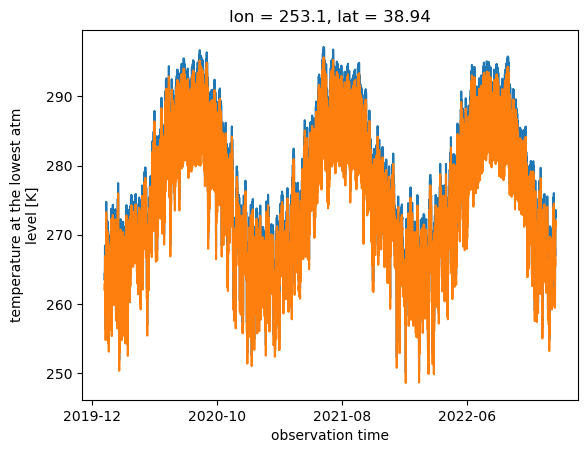

In [27]:
dsOut2.TBOT.isel(lat=0,lon=0).plot()
ds2.TBOT.isel(lat=0,lon=0).plot() ;


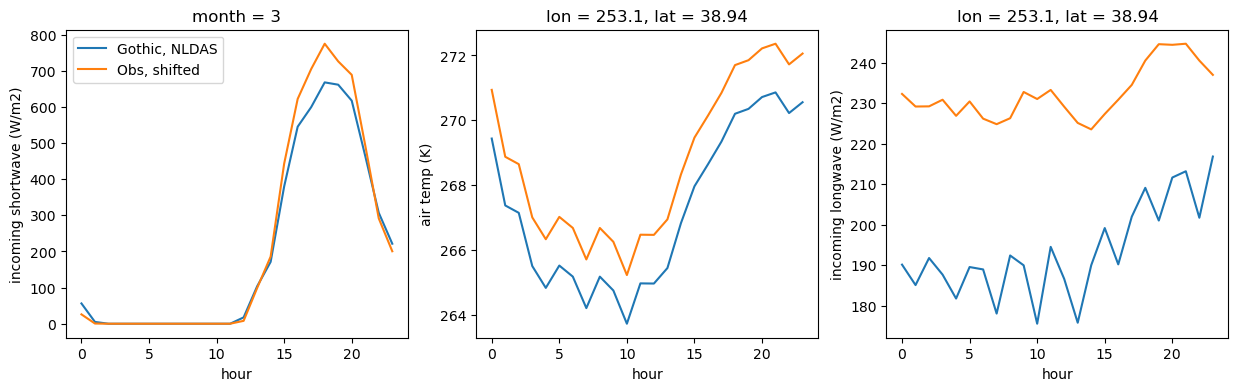

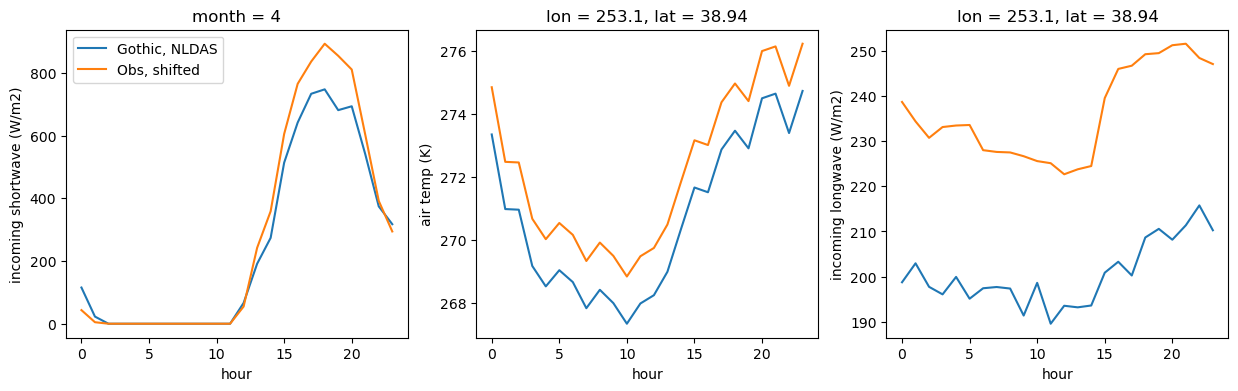

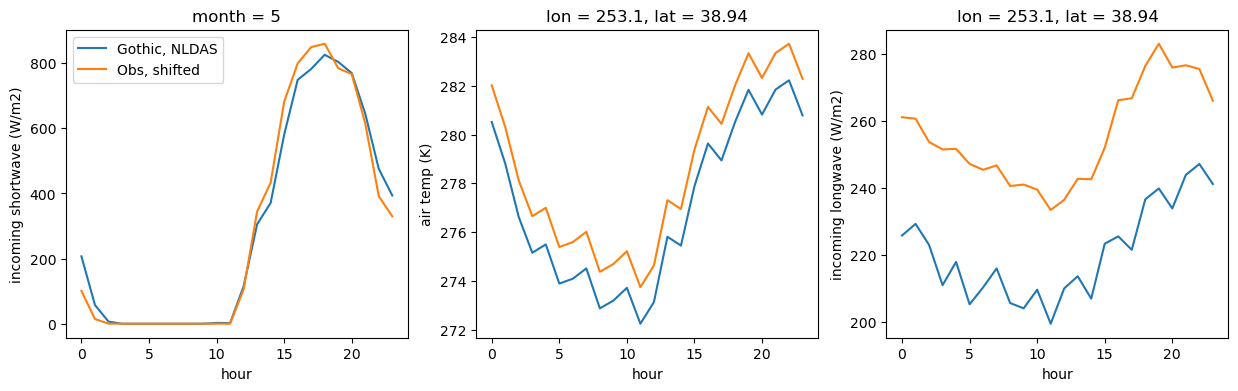

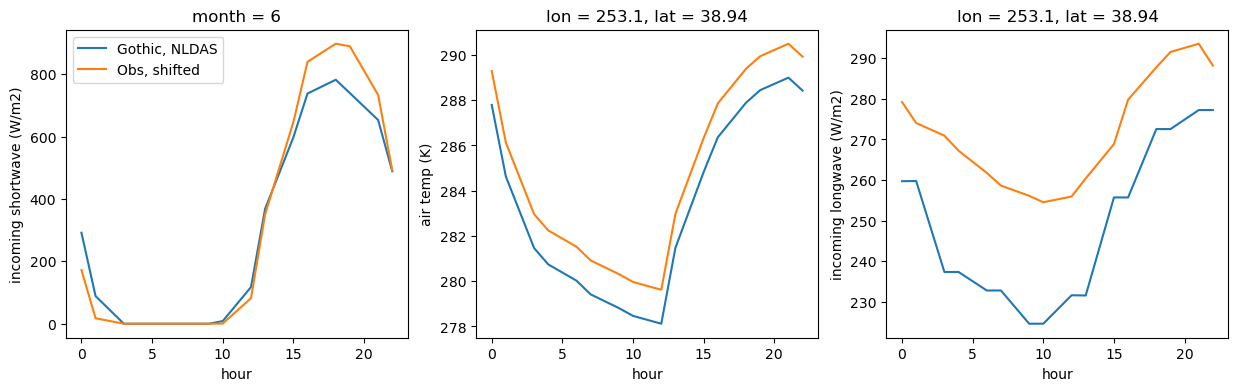

In [28]:
for nmonth in range(3,7):
    plt.figure(figsize=[15,4])
    plt.subplot(131)
    ds.FSDS.sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
    dsOut.FSDS.sel(time=dsOut.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Obs, shifted')
    plt.legend()
    plt.title('month = '+str(nmonth))
    plt.ylabel('incoming shortwave (W/m2)')
    
    plt.subplot(132)
    ds2.TBOT.sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
    dsOut2.TBOT.sel(time=dsOut2.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Obs, shifted')
    plt.ylabel('air temp (K)')
    
    plt.subplot(133)
    ds2.FLDS.sel(time=ds.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Gothic, NLDAS')
    dsOut2.FLDS.sel(time=dsOut2.time.dt.month.isin([nmonth])).groupby('time.hour').mean().plot(label='Obs, shifted')
    plt.ylabel('incoming longwave (W/m2)') ; 

In [29]:
fout = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2020-2022.nc'
if TBOT == True:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.TPQWL.gothic.2020-2022.nc'
elif TBOT == False:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo.c2020.TPQWL.gothic.2020-2022.nc'
else:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo_Warm'+str(TBOT)+'.c2020.TPQWL.gothic.2020-2022.nc'

dsOut.to_netcdf(fout)
dsOut2.to_netcdf(fout2)
print("wrote "+ fout)
print("wrote "+ fout2)

wrote /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2020-2022.nc
wrote /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo_Warm1.5.c2020.TPQWL.gothic.2020-2022.nc


`nccopy -k cdf5 /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2020-2022.nc /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo2.c2020.Solar.gothic.2020-2022.nc`

---

## Repeat above for 2000-2009 and 2010-2019 shortwave

In [30]:
data= np.concatenate((climo.in_short.values,climo.in_short.values,climo.in_short.values,
                     climo.in_short.values,climo.in_short.values,climo.in_short.values,
                     climo.in_short.values,climo.in_short.values,climo.in_short.values,
                     climo.in_short.values))

data2= np.concatenate((
    climo.TBOT.values,climo.TBOT.values,climo.TBOT.values,climo.TBOT.values,
    climo.TBOT.values,climo.TBOT.values,climo.TBOT.values,climo.TBOT.values,
    climo.TBOT.values,climo.TBOT.values,
)) + 273.15

data3= np.concatenate((
    climo.in_long.values,climo.in_long.values,climo.in_long.values,climo.in_long.values,
    climo.in_long.values,climo.in_long.values,climo.in_long.values,climo.in_long.values,
    climo.in_long.values,climo.in_long.values,
))



In [31]:
ds = xr.open_dataset(
    '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic.2000-2009.nc',
    decode_times=True)
ds2 = xr.open_dataset(
    '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic.2000-2009.nc',
    decode_times=True)

In [33]:
# Create data array with climatology
da = xr.DataArray(data= data,dims=["time"],
    coords=dict(time=ds.time),
    attrs=ds.FSDS.attrs)

da2 = xr.DataArray(data= data2,dims=["time"],
    coords=dict(time=ds2.time),
    attrs=ds2.TBOT.attrs)

da3 = xr.DataArray(data= data3,dims=["time"],
    coords=dict(time=ds2.time),
    attrs=ds2.FLDS.attrs)

# Expand dims and transpose as in NLDAS
da = da.expand_dims(lat=ds.lat, lon=ds.lon).transpose('time','lat','lon')
da2 = da2.expand_dims(lat=ds2.lat, lon=ds2.lon).transpose('time','lat','lon')
da3 = da3.expand_dims(lat=ds2.lat, lon=ds2.lon).transpose('time','lat','lon')

# Copy dataset for output
dsOut = ds.copy(deep=True)
dsOut['FSDS'] = da
dsOut['lat'] = ds.lat
dsOut['lon'] = ds.lon
dsOut['time'] = ds.time
dsOut

dsOut2 = ds2.copy(deep=True)
if TBOT == True: # Obs climo of TBOT
    dsOut2['TBOT'] = da2
elif TBOT == False: #NLDAS TBOT
    dsOut2['TBOT'] = dsOut2['TBOT']
else: #NLDAS + TBOT + warming
    dsOut2['TBOT'] = dsOut2['TBOT'] + TBOT

dsOut2['FLDS'] = da3
dsOut2['lat'] = ds2.lat
dsOut2['lon'] = ds2.lon
dsOut2['time'] = ds2.time
dsOut2

<xarray.Dataset>
Dimensions:  (time: 87600, lat: 1, lon: 1)
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2009-12-31 22:59:52.968750
  * lon      (lon) float32 253.1
  * lat      (lat) float32 38.94
Data variables:
    LONGXY   (lat, lon) float32 ...
    LATIXY   (lat, lon) float32 ...
    TBOT     (time, lat, lon) float32 267.6 267.3 267.0 ... 263.3 262.0 260.8
    PSRF     (time, lat, lon) float32 ...
    QBOT     (time, lat, lon) float32 ...
    WIND     (time, lat, lon) float32 ...
    FLDS     (time, lat, lon) float64 224.0 227.1 248.0 ... 224.2 219.4 223.4
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Temperature, Pressure...

In [34]:
fout = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2000-2009.nc'
if TBOT == True:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.TPQWL.gothic.2000-2009.nc'
elif TBOT == False:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo.c2020.TPQWL.gothic.2000-2009.nc'
else:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo_Warm'+str(TBOT)+'.c2020.TPQWL.gothic.2000-2009.nc'

dsOut.to_netcdf(fout)
dsOut2.to_netcdf(fout2)

print("wrote "+ fout)
print("wrote "+ fout2)

wrote /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2000-2009.nc
wrote /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo_Warm1.5.c2020.TPQWL.gothic.2000-2009.nc


In [35]:
ds = xr.open_dataset(
    '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.Solar.gothic.2010-2019.nc',
    decode_times=True)

ds2 = xr.open_dataset(
    '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.NLDAS2.c2020.TPQWL.gothic.2010-2019.nc',
    decode_times=True)

# Create data array with climatology
da = xr.DataArray(data= data,dims=["time"],
    coords=dict(time=ds.time),
    attrs=ds.FSDS.attrs)

da2 = xr.DataArray(data= data2,dims=["time"],
    coords=dict(time=ds2.time),
    attrs=ds2.TBOT.attrs)

da3 = xr.DataArray(data= data3,dims=["time"],
    coords=dict(time=ds2.time),
    attrs=ds2.FLDS.attrs)

# Expand dims and transpose as in NLDAS
da = da.expand_dims(lat=ds.lat, lon=ds.lon).transpose('time','lat','lon')
da2 = da2.expand_dims(lat=ds2.lat, lon=ds2.lon).transpose('time','lat','lon')
da3 = da3.expand_dims(lat=ds2.lat, lon=ds2.lon).transpose('time','lat','lon')

# Copy dataset for output
dsOut = ds.copy(deep=True)
dsOut['FSDS'] = da
dsOut['lat'] = ds.lat
dsOut['lon'] = ds.lon
dsOut['time'] = ds.time
dsOut

dsOut2 = ds2.copy(deep=True)
if TBOT == True: # Obs climo of TBOT
    dsOut2['TBOT'] = da2
elif TBOT == False: #NLDAS TBOT
    dsOut2['TBOT'] = dsOut2['TBOT']
else: #NLDAS + TBOT + warming
    dsOut2['TBOT'] = dsOut2['TBOT'] + TBOT

dsOut2['FLDS'] = da3
dsOut2['lat'] = ds2.lat
dsOut2['lon'] = ds2.lon
dsOut2['time'] = ds2.time
print(dsOut2)

fout = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2010-2019.nc'
if TBOT == True:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.TPQWL.gothic.2010-2019.nc'
elif TBOT == False:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo.c2020.TPQWL.gothic.2010-2019.nc'
else:
    fout2 = '/glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo_Warm'+str(TBOT)+'.c2020.TPQWL.gothic.2010-2019.nc'

dsOut.to_netcdf(fout)
dsOut2.to_netcdf(fout2)

print("wrote "+ fout)
print("wrote "+ fout2)

<xarray.Dataset>
Dimensions:  (time: 87600, lat: 1, lon: 1)
Coordinates:
  * time     (time) object 2010-01-01 00:00:00 ... 2019-12-31 22:59:52.968750
  * lon      (lon) float32 253.1
  * lat      (lat) float32 38.94
Data variables:
    LONGXY   (lat, lon) float32 ...
    LATIXY   (lat, lon) float32 ...
    TBOT     (time, lat, lon) float32 259.5 259.0 258.5 ... 270.0 268.1 266.2
    PSRF     (time, lat, lon) float32 ...
    QBOT     (time, lat, lon) float32 ...
    WIND     (time, lat, lon) float32 ...
    FLDS     (time, lat, lon) float64 224.0 227.1 248.0 ... 224.2 219.4 223.4
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Temperature, Pressure...
wrote /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.OBSclimo.c2020.Solar.gothic.2010-2019.nc
wrote /glade/campaign/cgd/tss/people/wwieder/gothic/datm_nldas/clmforc.FLDSclimo_Warm1.5.c2020.TPQWL.gothic.2010-2019.nc


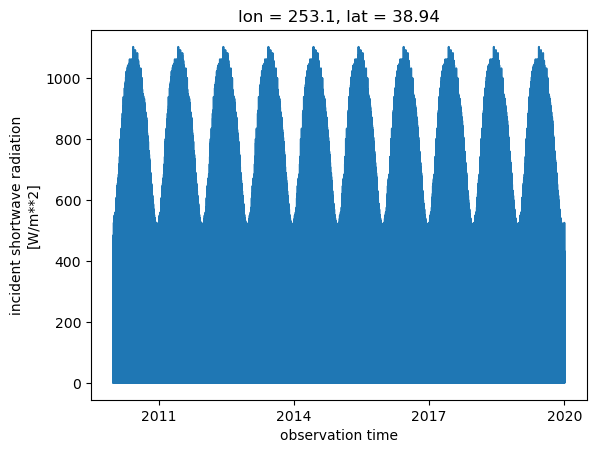

In [36]:
dsOut.FSDS.isel(lat=0,lon=0).plot() ;

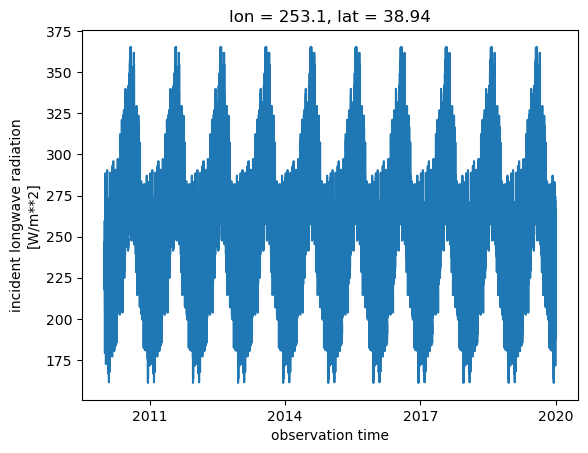

In [37]:
dsOut2.FLDS.isel(lat=0,lon=0).plot() ;